# Let's perform inference!
<!--- @wandbcode{ethz-hackathon} -->


In [1]:
from pathlib import Path
from types import SimpleNamespace
import torch, wandb
from miniminiai import show_images
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler

A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


You need to load the original model weights first:

In [2]:

config = SimpleNamespace(
    model_base="runwayml/stable-diffusion-v1-5",
    device="cuda",
)

WANDB_PROJECT_NAME="ethz-hackathon"
LORA_WEIGHTS_AT="capecape/ethz-hackathon/zenjyi59_dreambooth_lora:v0"

Create the diffusion Pipeline

In [20]:

pipe = DiffusionPipeline.from_pretrained(config.model_base, torch_dtype=torch.float16)
# pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Let's create a W&B run

In [13]:


run = wandb.init(project=WANDB_PROJECT_NAME, job_type="inference", group="lora", config=config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: capecape. Use `wandb login --relogin` to force relogin


Let's create a Table to keep track of all our generations

In [21]:
table = wandb.Table(columns=["image", "num_inference_steps", "guidance_scale", "cross_attn_scale"])

Load the LoRA attention weights on top of the pretrained Stable Diffusion model

In [22]:
at = run.use_artifact(LORA_WEIGHTS_AT, type="model")
lora_model_path = list(Path(at.download()).glob("*.bin"))[0]

wandb:   1 of 1 files downloaded.  


In [23]:
pipe.load_lora_weights(lora_model_path)
pipe.to(config.device);

In [23]:

# older diffusers style loading
# pipe.unet.load_attn_procs(lora_model_path)

# new diffusers and Dreambooth style loading
pipe.load_attn_procs(lora_model_path)
pipe.to(config.device);

AttributeError: 'StableDiffusionPipeline' object has no attribute 'load_attn_procs'

Define some prompts

In [24]:
prompts = ["A picture of sks dog in the beach.", 
           "A picture of sks dog in the style of van goghg", ]
        #    "A picture of sks dog with sunglasses", 
        #    "a picture of sks dog with a hat"]

Generating with 50% conditioning (interpolating base weights and LoRA weigths)

In [28]:
def generate_images(prompts, num_inference_steps=25, guidance_scale=7.5, cross_attn_scale=0.5):
    images = pipe(
        prompts,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        cross_attention_kwargs={"scale": cross_attn_scale},
    ).images
    for img in images:
        table.add_data(wandb.Image(img),  num_inference_steps, guidance_scale, cross_attn_scale)
    return images

100%|██████████| 25/25 [00:03<00:00,  8.05it/s]


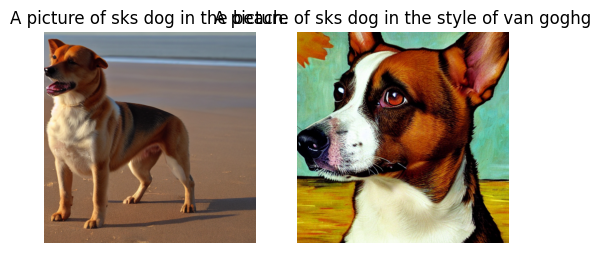

In [29]:
images = generate_images(prompts)
show_images(images, titles=prompts, nrows=1)

Full LoRA

100%|██████████| 25/25 [00:03<00:00,  8.06it/s]


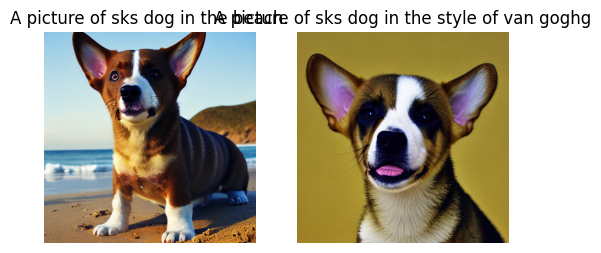

In [30]:

images = generate_images(prompts, cross_attn_scale=1.0)
show_images(images, titles=prompts, nrows=1)